# KNN Data Preparation
This Notebook will cover the data preparation process before being tested in the KNN model<br><br>

Source regarding for the method used:
- [Optimizing dynamic time warping’s window width for time series data mining applications](https://link.springer.com/article/10.1007/s10618-018-0565-y)
- [Dynamic Time Warping Notebook](https://github.com/MJeremy2017/machine-learning-models/blob/master/Dynamic-Time-Warping/dynamic-time-warping.ipynb)
- [Timeseries Classification: KNN & DTW](https://nbviewer.jupyter.org/github/markdregan/K-Nearest-Neighbors-with-Dynamic-Time-Warping/blob/master/K_Nearest_Neighbor_Dynamic_Time_Warping.ipynb)
- [Time Series Classification and Clustering with Python](http://alexminnaar.com/2014/04/16/Time-Series-Classification-and-Clustering-with-Python.html)
- [K-Nearest-Neighbors-with-Dynamic-Time-Warping](https://github.com/markdregan/K-Nearest-Neighbors-with-Dynamic-Time-Warping)
- [Accurate Real-time Windowed Time Warping](https://www.semanticscholar.org/paper/Accurate-Real-time-Windowed-Time-Warping-Macrae-Dixon/179212e590e8871076e682188a91e43bea2e44eb)
- [Gregory R. Lee, Ralf Gommers, Filip Wasilewski, Kai Wohlfahrt, Aaron O’Leary (2019). PyWavelets: A Python package for wavelet analysis. Journal of Open Source Software, 4(36), 1237, ](https://doi.org/10.21105/joss.01237.)
- [Wavelet Transform](https://towardsdatascience.com/the-wavelet-transform-e9cfa85d7b34)
- [Mallat Algorithm](https://www.researchgate.net/figure/Mallat-algorithm-for-DWT-decomposition_fig17_292962606)
- [Type of Wavelet](http://wavelets.pybytes.com/wavelet/sym4/)
- [DWT Wikipedia](https://en.wikipedia.org/wiki/Discrete_wavelet_transform)

## Import

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
import matplotlib.cbook
from scipy.signal import find_peaks
from numpy.lib.stride_tricks import sliding_window_view
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

## Data Loading

In [6]:
ecg20 = np.loadtxt(".\RawData\ecgrate20bpm.txt")
ecg40 = np.loadtxt(".\RawData\ecgrate40bpm.txt")
ecg80 = np.loadtxt(".\RawData\ecgrate80bpm.txt")

pvc6 = np.loadtxt(".\RawData\pvc6permnt.txt")
pvc12 = np.loadtxt(".\RawData\pvc12permnt.txt")
pvc24 = np.loadtxt(".\RawData\pvc24permnt.txt")

ecg80tst = np.loadtxt(".\RawData\Data\ecgrate80bpmdt12")


## Data Visualization
1/20 of Data is used for Visualization

In [ ]:
# %matplotlib widget
ax1, ax2, ax3, ax4, ax5, ax6, ax7 = None, None, None, None, None, None, None
ax = [ax1, ax2, ax3, ax4, ax5, ax6, ax7]
text = [
    "ECG 20 BPM",
    "ECG 40 BPM",
    "ECG 80 BPM",
    "PVC 6 Per Menit",
    "PVC 12 Per Menit",
    "PVC 24 Per Menit",
    "PVC Test",
]
var = [ecg20, ecg40, ecg80, pvc6, pvc12, pvc24, ecg80tst]
div = 20
fs = 250

for i, j in enumerate(ax):
    dat = var[i][: var[i].shape[0] // div]
    peaks, _ = find_peaks(dat, height=2.5)
    j = plt.subplot(7, 1, i + 1)
    j.title.set_text(text[i])
    j.plot(np.arange(var[i].shape[0] // div) / fs, dat)
    j.plot(peaks / fs, dat[peaks], "x")

<div>
<img src="DataViz.png" alt="Drawing" width="600"/>
</div>

## Data Exploring
Exploring data to find the base viewing window to make the data set using the explorer class

In [8]:
class explorer:
    def __init__(
        self,
        data,
        dataname,
        window,
        winratio=0.3,
        normheight=2.5,
        pvcheight=2,
        pvcdetect=False,
        fs=250,
    ):
        self.data = data
        self.dataname = dataname
        self.normheight = normheight
        self.pvcheight = pvcheight
        self.window = window
        self.winratio = winratio
        self.pvcdetect = pvcdetect
        self.fs = fs

        self.peakindexer()
        self.labeling()

    def peakindexer(self):
        peaks, _ = find_peaks(
            self.data,
            height=self.normheight,
        )
        self.peaks = peaks[(peaks < (self.data.shape[0] - (self.window - 1)))]
        if self.pvcdetect:
            pvcpeaks, _ = find_peaks(
                -self.data,
                height=self.pvcheight,
            )
            self.pvcpeaks = pvcpeaks[
                (pvcpeaks < (self.data.shape[0] - (self.window - 1)))
            ]

    def labeling(self):
        winrawdat = sliding_window_view(self.data, self.window)

        self.windowpeaks = self.peaks - (self.winratio * self.window)
        self.windowpeaks = self.windowpeaks.astype(int)
        self.labeleddata = winrawdat[self.windowpeaks, :]
        if self.pvcdetect:
            self.pvcwindowpeaks = self.pvcpeaks - (self.winratio * self.window)
            self.pvcwindowpeaks = self.pvcwindowpeaks.astype(int)
            self.pvclabeleddata = winrawdat[self.pvcwindowpeaks, :]

    def labelplotter(self, datalabel, peaks, title, labeldiv, datadiv):

        fig = plt.figure(figsize=[7, 35])
        fig.suptitle(title)

        ax = fig.add_subplot(labeldiv + 3, 1, 1)
        ax.plot(
            np.arange(self.data.shape[0] // datadiv) / self.fs,
            self.data[: self.data.shape[0] // datadiv],
        )
        ax.plot(
            peaks[(peaks < self.data.shape[0] // datadiv)] / self.fs,
            self.data[peaks[(peaks < self.data.shape[0] // datadiv)]],
            "x",
        )
        ax.title.set_text("Marked Peaks (1/"+str(datadiv)+" Data)")

        plotlist = np.argwhere(
            np.arange(datalabel.shape[0]) % (datalabel.shape[0] // labeldiv) == 0
        )
        for i, j in enumerate(datalabel[plotlist]):
            ax = fig.add_subplot(labeldiv + 3, 1, i + 2)
            ax.plot(np.arange(self.window) / self.fs, j[0])
            ax.title.set_text("Data ke " + str(plotlist[i][0]))
        fig.add_subplot(labeldiv + 3, 1, labeldiv + 3).plot(
            np.arange(self.window) / self.fs, datalabel[-1]
        )
        fig.add_subplot(labeldiv + 3, 1, labeldiv + 3).title.set_text("Data Terakhir")
        fig.tight_layout(rect=[0, 0, 1, 0.98])

    def info(self):
        print(
            f"""
        Data = {self.dataname}
        Window = {self.window}
        Window Ratio = {self.winratio}
        Height Threshold = {self.normheight}"""
        )
        if self.pvcdetect:
            print(
                f"""        PVC Threshold = {self.pvcheight}
            """
            )
        print(
            f"""        Sampling Frequency = {self.fs}

        Data Shape = {self.data.shape[0]}
        Indexed Peaks Shape= {self.peaks.shape[0]}
        """
        )
        if self.pvcdetect:
            print(
                f"""
            PVC Peaks Shape = {self.pvcpeaks.shape[0]}
            """
            )

    def preview(self, labeldiv=5, datadiv=20):
        self.info()
        self.labelplotter(
            self.labeleddata,
            self.peaks,
            "Normal ECG",
            labeldiv=labeldiv,
            datadiv=datadiv,
        )
        if self.pvcdetect:
            self.labelplotter(
                self.pvclabeleddata,
                self.pvcpeaks,
                "PVC",
                labeldiv=labeldiv,
                datadiv=datadiv,
            )

### ECG 20 BPM Exploration


        Data = ECG 20
        Window = 80
        Window Ratio = 0.3
        Height Threshold = 2.5
        Sampling Frequency = 250

        Data Shape = 38171
        Indexed Peaks Shape= 137
        


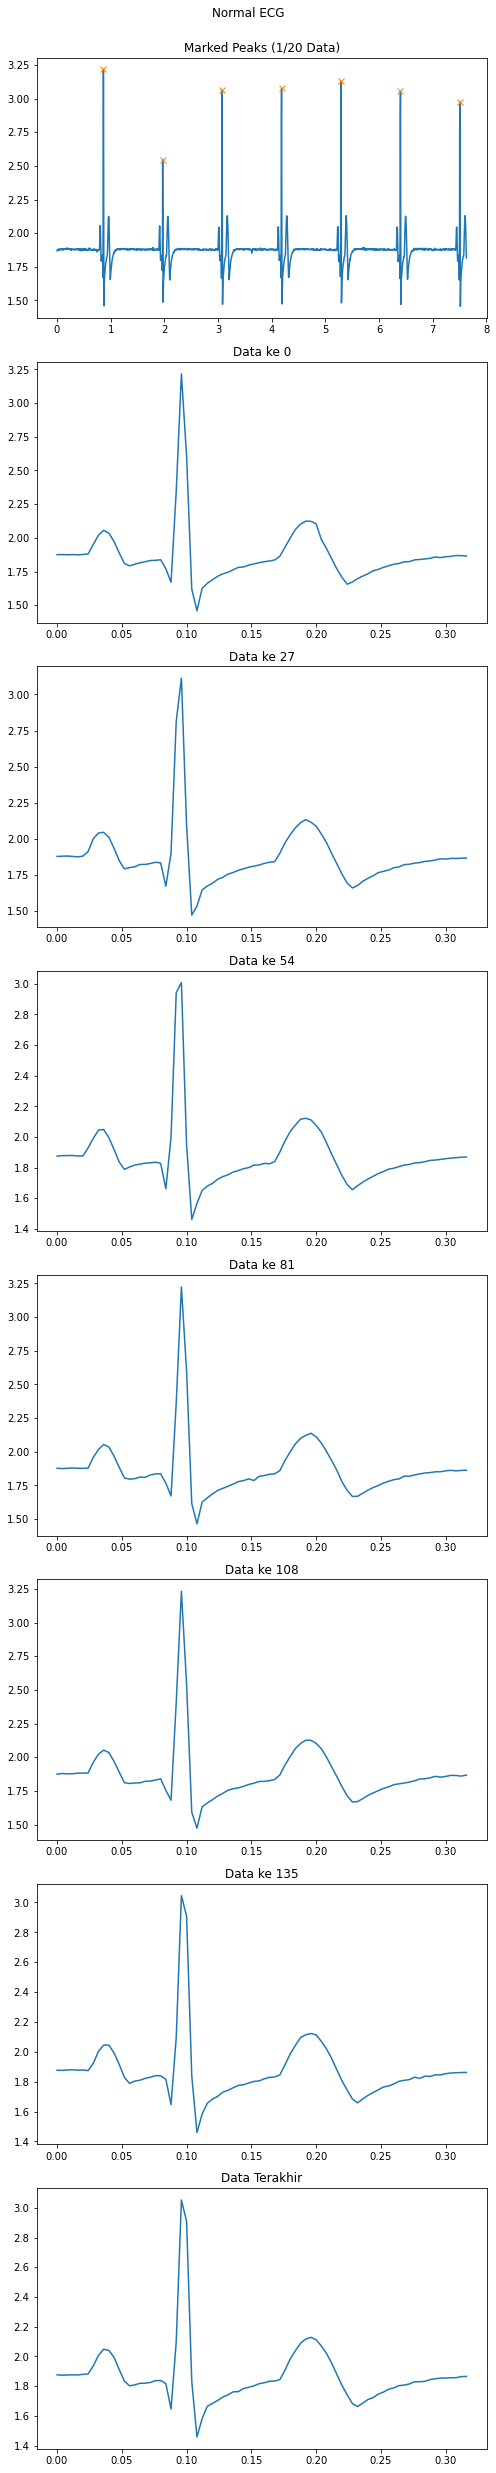

In [9]:
ecg20explore = explorer(ecg20,"ECG 20",window=80, winratio=0.3)
ecg20explore.preview()

### ECG 40 BPM Exploration


        Data = ECG 40
        Window = 100
        Window Ratio = 0.3
        Height Threshold = 2.5
        Sampling Frequency = 250

        Data Shape = 31640
        Indexed Peaks Shape= 228
        


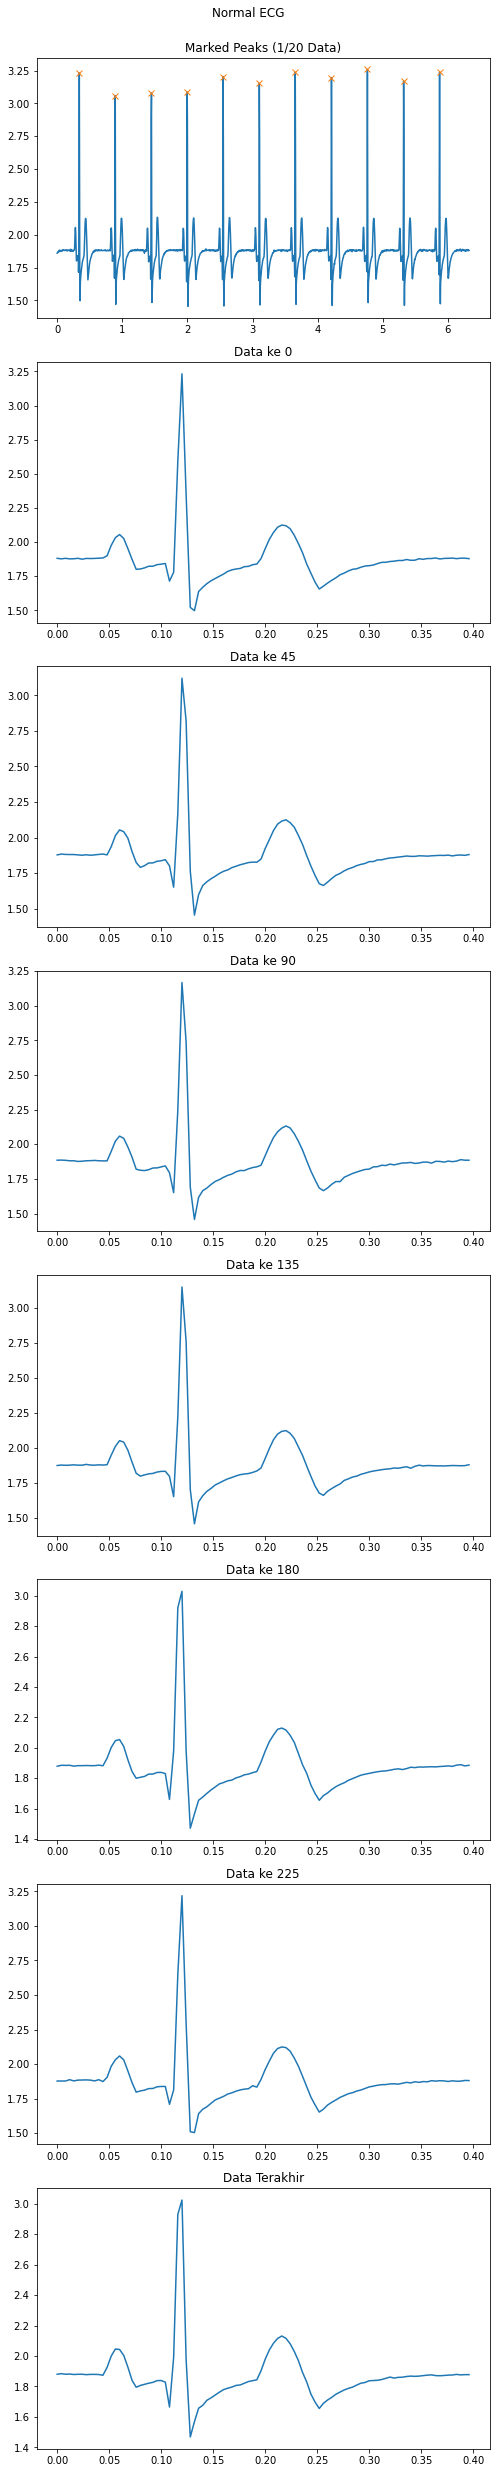

In [12]:
ecg40explorer = explorer(ecg40,"ECG 40", window=100, winratio=0.3)
ecg40explorer.preview()

In [ ]:
class DWT:
    def __init__(self, data, wavelet, level=1):
        self.data = data
        self.wavelet = wavelet
        self.level = level
